In this notebook we discuss the access of `LINEAR` data, selection of RR Lyrae stars and the subsequent access and processing of `ZTF` data for the corresonding `LINEAR` stars.

# Notebook configuration

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample
from astroML.datasets import fetch_LINEAR_geneva
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astroML.time_series import MultiTermFit

# ZTF
from ztfquery import lightcurve

# Basic libraries
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# CONFIGURATION
# -------------
sns.set_theme() # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)

# configuring plotting colors
colors = ['#5F6372', '#79A8A4', '#B2AD8F', '#92A186', '#AD8082']
blue = '#5F6372'
turqoise = '#79A8A4'
light_green = '#B2AD8F'
green = '#92A186'
pink = '#AD8082'
cmap = mcolors.ListedColormap(colors)

# configuring fonts for plotting
font = FontProperties()
font.set_family('avenir')
font.set_name('Big Caslon')
font.set_style('normal')
font.set_size('xx-large')


%matplotlib inline  

In [4]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
from data_access import*

# Accessing `LINEAR` data

## Information about the `LINEAR` dataset

The `LINEAR dataset` *(Lincon Near-Earth Asteroid Research)* contains 7010 light curves of periodic variable stars. While the original mission of this survey was to find asteroids, it subsequently monitored a substantial portion of the sky, cataloging the brightness of various variable stars. This survey was operated with two telescopes on a site in New Mexico. The two telescopes are equatorially mounted of GEODSS type, where each telescope is denoted as L1 and L2. They observed a broad part of the visible spectrum and the near-infrared spectrum. 

The preprocessing process contained the following procedures:
1. **Bias correction**: removing noise created by the camera
2. **Flat-field correction**: removing artificial lines and gradients due to varying sensitivities of pixels
3. **Preliminary fixed-aperture photometry**: subtracting the background light using Poisson statistics

After preprocessing, the data had to be astrometrically recalibrated, meaning that the scientists had to ensure the coordinates of the objects in the data matched another survey, like SDSS. Of all the data, 7% had bad astrometry (the coordinates did not fit), so the scientists removed them from the dataset. The rest of the data had a 1-2% error in astrometry.

Next up was photometric recalibration, meaning that the filters and fluxes had to be recalibrated to match SDSS data. The corrections regarded CCD camera errors, correcting the magnitudes of objects in the data, and correcting underestimated magnitude errors. After the photometric recalibration, the data were grouped into various categories, including a variable star category. While the original dataset has 5 billion objects, *only 7010 are confirmed periodic variable stars*. The scientists subsequently analyzed this portion of the dataset by categorizing the light curves, calculating their periods, and inferring conclusions from the preceding factors. 

## Downloading `LINEAR` data

We can access the `LINEAR` dataset via one line of code since we are downloading the data from the AstroML library.

In [5]:
#| code-fold: false
# LINEAR DATA
# ------------
dataL = fetch_LINEAR_sample(data_home='../inputs')

In [6]:
print(f'The number of light curves in the LINEAR dataset:{len(dataL.ids)}') 

The number of light curves in the LINEAR dataset:7010


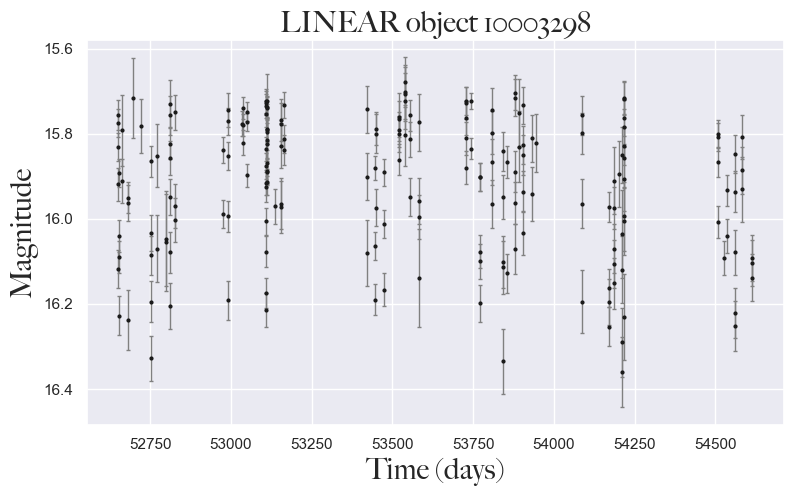

In [7]:
#| code-fold: False
# Plotting an example of a LINEAR light curve

ID = dataL.ids[0] # accessing the first LINEAR ID
lc = dataL.get_light_curve(ID)
time, mag, magerr = lc.T # transposing the data

#--------
# accessing the coordinates for the star
targets = dataL.targets[0]
ra, dec = targets[3], targets[4]
#--------
fig, ax = plt.subplots(1,1, figsize=(9,5)) # creating subplots with 2 columms and 3 rows
ax.errorbar(time, mag, magerr, fmt='.k', ecolor='gray',lw=1, ms=4, capsize=1.5)
ax.set_xlabel('Time (days)',fontproperties=font)
ax.set_ylabel('Magnitude', fontproperties=font)
ax.set_title('LINEAR object {0}'.format(ID), fontproperties=font)
ax.invert_yaxis()
plt.show()

## Structure of `LINEAR` data

The structure of the `LINEAR` dataset is as such:
1. `dataL` is a `AstroML.datasets` object and it contains the following:

1.a `dataL.ids` is a list of all the IDs of the stars

1.b `dataL.get_light_curve()` is a function which acceses the data for a specific ID of a light curve every light curve is a `np.array()` object where every column is `time`, `magnitude` and the  `magnitude error`. In order to get an array for every column the original array must be transposed.

2. `dataL.targets` contains all of the metadata for every light curve eg. rectascension, declination, etc.


# Selecting `LINEAR` RR Lyrae stars

In order to begin with the selection of RR Lyrae stars which we will use in this research paper, we need the classification type of each star along with color information. We access data with the `fetch_LINEAR_geneva()` which contains additional information about the light curves in the **Geneva catalog** of the `LINEAR` variable stars.

We have calculated the periods of the RR Lyrae stars beforehand with only 3 Fourier coefficients, enough to differentiate "1 dip" and "2 dip" stars. You can find the entire code for `select_LINEAR` in the `selection.py` file.

### Selecting good `LINEAR` stars

In [22]:
dataPeriods = fetch_LINEAR_geneva() # accessing the good data
dataPeriodsdf = pd.DataFrame(dataPeriods)
dataPeriodsdf.head()

,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype,LINEARobjectID
0,119.526443,46.962120,1.166,0.369,1.018,0.269,-0.254138,0.619,-0.313,-0.567,16.37,301,1,29848
1,119.324013,47.095505,1.356,0.521,1.167,0.311,-0.244691,0.709,-0.493,-0.997,15.02,289,1,32086
2,118.503448,49.686569,1.166,0.138,1.154,0.384,-0.609386,0.601,-0.052,-0.447,16.14,245,1,43542
3,119.712975,52.149574,1.175,0.386,1.100,0.205,-0.191591,0.487,-0.291,-0.879,16.46,284,1,50402
4,118.491257,53.168125,0.805,0.554,1.618,0.198,-0.178900,0.695,-0.026,-1.059,14.08,274,1,61011


In [25]:
dataPeriodsdf['period'] = 10**dataPeriodsdf['logP']
dataPeriodsdf.head()

,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype,LINEARobjectID,period
0,119.526443,46.962120,1.166,0.369,1.018,0.269,-0.254138,0.619,-0.313,-0.567,16.37,301,1,29848,0.557009
1,119.324013,47.095505,1.356,0.521,1.167,0.311,-0.244691,0.709,-0.493,-0.997,15.02,289,1,32086,0.569258
2,118.503448,49.686569,1.166,0.138,1.154,0.384,-0.609386,0.601,-0.052,-0.447,16.14,245,1,43542,0.245818
3,119.712975,52.149574,1.175,0.386,1.100,0.205,-0.191591,0.487,-0.291,-0.879,16.46,284,1,50402,0.643293
4,118.491257,53.168125,0.805,0.554,1.618,0.198,-0.178900,0.695,-0.026,-1.059,14.08,274,1,61011,0.662369


In [28]:
original_Lids = dataL.ids
new_lids = dataPeriodsdf['LINEARobjectID'].to_numpy()
select_period = pd.DataFrame()
for i in original_Lids:
    for j in range(len(new_lids)):
        if i==new_lids[j]:
            row = pd.DataFrame(dataPeriodsdf.iloc[[j]]) # assign the current row we are analyzing
            select_period = pd.concat([select_period, row.reset_index(drop=True)], ignore_index=True, axis=0)
select_period.head()

,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype,LINEARobjectID,period
0,207.529404,33.706001,1.846,1.117,1.388,0.635,-0.605701,0.493,0.660,-0.483,15.89,196,5,10003298,0.247913
1,206.096115,36.648674,1.717,1.065,1.894,0.623,-0.146253,0.580,2.227,4.287,15.50,170,4,10013411,0.714081
2,206.229523,38.758453,0.996,0.047,1.018,0.380,-0.238884,0.742,-0.624,-0.566,14.99,214,1,10021274,0.576921
3,207.355225,39.589951,1.315,0.354,1.387,0.173,-0.210446,0.740,-0.550,-0.498,14.29,246,1,10022663,0.615962
4,206.805511,40.859066,1.610,0.854,1.583,0.571,-0.559325,0.673,0.480,0.094,15.85,233,5,10025796,0.275851


In [29]:
print(select_period.shape)

(5204, 15)


In [32]:
Lrrlyr1 = select_period[(select_period['gi']>-0.5)&(select_period['gi']<0.4)&(select_period['LCtype']>0)&(select_period['LCtype']<3)] # RR lyrae type
Lrrlyr1 = Lrrlyr1.reset_index(drop=True)
#Lrrlyr.to_csv('../outputs/Lrrlyr_unprocessed.csv',index=False)
#Lab = Lrrlyr[Lrrlyr['LCtype']==1] # RRab type
#Lc = Lrrlyr[Lrrlyr['LCtype']==2] # RRc type
#print(len(Lab), len(Lc))
print(Lrrlyr1.shape)
Lrrlyr1.head()

(2941, 15)


,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype,LINEARobjectID,period
0,206.229523,38.758453,0.996,0.047,1.018,0.380,-0.238884,0.742,-0.624,-0.566,14.99,214,1,10021274,0.576921
1,207.355225,39.589951,1.315,0.354,1.387,0.173,-0.210446,0.740,-0.550,-0.498,14.29,246,1,10022663,0.615962
2,207.177231,41.918797,1.194,-0.310,0.327,0.253,-0.263546,0.782,-0.941,-0.066,15.33,255,1,10030349,0.545072
3,206.020233,41.646141,1.170,0.033,0.934,0.345,-0.445620,0.415,0.075,-1.285,15.22,193,2,10032668,0.358410
4,206.387268,43.314617,1.175,0.250,1.126,0.340,-0.303929,0.459,-0.530,0.721,15.50,227,1,10038903,0.496673


In [39]:
LIDS1 = Lrrlyr1['LINEARobjectID'].to_numpy()
lids2 = Lrrlyr['ID'].to_numpy()
missing = []
for i in LIDS1:
    c = 0
    for j in lids2:
        if i==j:
            c += 1
    if c==0:
        missing.append(i)
print(missing)

[10071455, 10232710, 10278022, 1032186, 10405664, 10696063, 10799030, 1080552, 10814742, 10820520, 10869160, 11166089, 1124773, 11256803, 11266259, 11269883, 11365516, 11476683, 11492977, 11657158, 11681432, 11693233, 1169665, 11905739, 12275391, 12320224, 12364597, 12390014, 12392541, 12402647, 12566108, 12682467, 12754432, 13009885, 1305630, 13198074, 13313044, 13419213, 13425897, 13714791, 13716218, 13914040, 1391917, 14155972, 14219893, 14426666, 14468317, 14511201, 14539006, 14693239, 14713979, 14738928, 14742763, 14846415, 14903357, 1491775, 14920151, 15229778, 15240181, 15245551, 15246422, 15269598, 15287382, 15410217, 15456038, 15521107, 15617295, 15621227, 15708768, 15820290, 15836441, 1602363, 16075048, 16132098, 16192469, 16235958, 1626282, 16540332, 16560563, 16659561, 16776795, 17165200, 17312184, 17342686, 17729039, 1774383, 17792324, 18021143, 18178441, 18210795, 18232336, 18373326, 18415157, 18543464, 18557434, 18563582, 18783106, 18861334, 18863221, 18892285, 18912216,

In [42]:
filtered_Lrrlyr = Lrrlyr1[Lrrlyr1['LINEARobjectID'].isin(missing)]
filtered_Lrrlyr.head()

,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype,LINEARobjectID,period
13,206.223587,6.741248,1.148,-0.040,0.886,0.176,-0.531926,0.960,3.365,13.012,15.62,269,2,10071455,0.293815
28,209.674210,16.421736,1.137,0.153,1.063,0.367,-0.554860,0.607,0.855,1.230,16.76,202,2,10232710,0.278702
35,209.188583,26.111385,1.161,0.158,1.012,0.142,-0.401182,0.449,-0.079,-0.439,16.55,262,2,10278022,0.397025
38,169.357468,57.331566,1.233,-0.090,0.853,0.276,-0.485150,0.327,-0.223,0.348,16.14,140,2,1032186,0.327228
57,208.532242,6.762656,1.188,-0.055,0.654,-0.012,-0.573168,0.294,2.005,10.351,15.65,235,2,10405664,0.267197


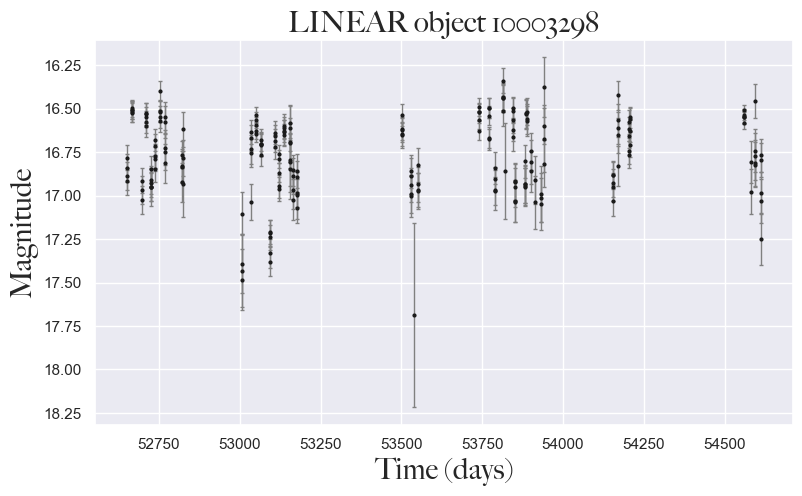

In [44]:
#| code-fold: False
# Plotting an example of a LINEAR light curve

ID = dataL.ids[0] # accessing the first LINEAR ID
lc = dataL.get_light_curve(10232710)
time, mag, magerr = lc.T # transposing the data

#--------
# accessing the coordinates for the star
targets = dataL.targets[0]
ra, dec = targets[3], targets[4]
#--------
fig, ax = plt.subplots(1,1, figsize=(9,5)) # creating subplots with 2 columms and 3 rows
ax.errorbar(time, mag, magerr, fmt='.k', ecolor='gray',lw=1, ms=4, capsize=1.5)
ax.set_xlabel('Time (days)',fontproperties=font)
ax.set_ylabel('Magnitude', fontproperties=font)
ax.set_title('LINEAR object {0}'.format(ID), fontproperties=font)
ax.invert_yaxis()
plt.show()

---

In [33]:
NAME = 'LINEAR_Periods_nterm3'
colnames = ['ID','Porig','Pnew','ra','dec', 'ug','gi','iK','JK','logP','Ampl','skew','kurt','magMed','nObs','LCtype']

In [34]:
if os.path.isfile("../outputs/"+ NAME+".txt"): # if this file exists
    print('Loading LINEAR data!')
    LINEAR_periods = txt_to_pandas(NAME, colnames)
else:
    goodIDs,goodPeriodOrig,goodPeriodNew,goodOrigIndex,dataPeriods,LINEAR_data = select_good_LINEAR(NAME, dataL)
    LINEAR_data = saving_linear_periods(NAME, goodIDs,goodPeriodOrig,goodPeriodNew,goodOrigIndex,dataPeriods,LINEAR_data)
    LINEAR_periods = txt_to_pandas(NAME, colnames)

Loading LINEAR data!


In [35]:
LINEAR_periods.head()

,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype
0,29848,0.557009,0.557019,119.526443,46.962120,1.17,0.37,1.02,0.27,-0.254138,0.62,-0.31,-0.57,16.37,301,1
1,32086,0.569258,0.569266,119.324013,47.095505,1.36,0.52,1.17,0.31,-0.244691,0.71,-0.49,-1.00,15.02,289,1
2,50402,0.643293,0.643286,119.712975,52.149574,1.18,0.39,1.10,0.20,-0.191591,0.49,-0.29,-0.88,16.46,284,1
3,61011,0.662369,0.662376,118.491257,53.168125,0.81,0.55,1.62,0.20,-0.178900,0.69,-0.03,-1.06,14.08,274,1
4,62892,0.530772,0.530764,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1


### Selecting RR Lyrae stars

We have now selected all of the "good" `LINEAR` IDs, now we need to select the RR Lyrae stars.

We first select "1 dip stars" using the coefficient between the original (correct) and our calculated period. Since 1 dip stars are easy to calculate periods for, they should match very well (from a range from 0.99 to 1.01). However, Eclipsing Binaries do not match up well, and often times have a ratio where our calculated period is 2 times bigger than the correct one. This is the easiest way to differentiate the two.

In [36]:
#| code-fold: false
# SELECTING 1 dip STARS
# -------------------------

P_ratio = LINEAR_periods['Porig']/LINEAR_periods['Pnew']

LINEAR_periods_1 = LINEAR_periods[(P_ratio>0.99)&(P_ratio<1.01)] # where the ratio between the originaLINEAR_periods (correct) and currentLINEAR_periodsy caLINEAR_periodscuLINEAR_periodsated periods are 1:1
LINEAR_periods_1.head()

,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype
0,29848,0.557009,0.557019,119.526443,46.962120,1.17,0.37,1.02,0.27,-0.254138,0.62,-0.31,-0.57,16.37,301,1
1,32086,0.569258,0.569266,119.324013,47.095505,1.36,0.52,1.17,0.31,-0.244691,0.71,-0.49,-1.00,15.02,289,1
2,50402,0.643293,0.643286,119.712975,52.149574,1.18,0.39,1.10,0.20,-0.191591,0.49,-0.29,-0.88,16.46,284,1
3,61011,0.662369,0.662376,118.491257,53.168125,0.81,0.55,1.62,0.20,-0.178900,0.69,-0.03,-1.06,14.08,274,1
4,62892,0.530772,0.530764,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1


Now, we select the *RR Lyrae* stars using the color filter values `(g-i)` and the light curve classification `(LCtype)`. 

In [37]:
#| code-fold: false
Lrrlyr = LINEAR_periods_1[(LINEAR_periods_1['gi']>-0.5)&(LINEAR_periods_1['gi']<0.4)&(LINEAR_periods_1['LCtype']>0)&(LINEAR_periods_1['LCtype']<3)] # RR lyrae type
Lrrlyr = Lrrlyr.reset_index(drop=True)
Lrrlyr.to_csv('../outputs/Lrrlyr_unprocessed.csv',index=False)
Lab = Lrrlyr[Lrrlyr['LCtype']==1] # RRab type
Lc = Lrrlyr[Lrrlyr['LCtype']==2] # RRc type
print(len(Lab), len(Lc))
Lrrlyr.head()

2144 566


,ID,Porig,Pnew,ra,dec,ug,gi,iK,JK,logP,Ampl,skew,kurt,magMed,nObs,LCtype
0,29848,0.557009,0.557019,119.526443,46.962120,1.17,0.37,1.02,0.27,-0.254138,0.62,-0.31,-0.57,16.37,301,1
1,50402,0.643293,0.643286,119.712975,52.149574,1.18,0.39,1.10,0.20,-0.191591,0.49,-0.29,-0.88,16.46,284,1
2,62892,0.530772,0.530764,119.187241,53.379295,1.12,0.21,1.07,0.21,-0.275092,0.62,-0.55,-0.32,16.54,276,1
3,91437,0.674728,0.674711,120.294960,40.932457,1.18,0.24,1.09,0.37,-0.170871,0.75,-0.12,-0.93,15.39,177,1
4,95250,0.313869,0.313869,120.124542,40.656620,1.18,-0.14,0.83,0.28,-0.503252,0.55,0.14,-0.65,16.98,222,2


We now have 2710 RR Lyrae stars from the `LINEAR` database. We can differentiate them further into *RR Lyrae AB* and *RR Lyrae C* types, but this can be done later (we just have to conserve the `LCtype` column).

# `ZTF` data

## Some information about `ZTF` data

The `Zwicky Transient Facility` is an optical time-domain survey that uses the Palomar 48-inch Schmidt telescope to observe the entire Northern hemisphere sky in 3 different bands: `g,` `r`, and `i`, and has been operating since October 2017. This telescope has a large field of view, taking in a lot of data.

All the data gathered by `ZTF` is stored at the IPAC, which can be accessed via IRSA, as shown in this project. All of the raw data was processed so that every pixel had an average of 5 bits, and although this increased sky noise by 1%, the increase is negligible. All the images were FITS images which the program processed in the following way:

1. **Preprocessing:** removing bias frames and flat field correction frames.

2. **Astrometry:** Using the `SCAMP` package, all objects were astrometrically calibrated to match the `GAIA` survey.

3. **Photometry:** All images were photometrically calibrated following the `PanSTARRS 1` survey.

4. **Final processing:** Finally, masks were made for saturation, bad pixels were removed, ghosts and any instrumental artifacts, and other defects.


Every image was then categorized as either a moving or a changing source using the `ZOGY` algorithm. Furthermore, point-like moving objects were identified using the custom `ZTF Moving-object Discovery Engine (ZMODE).` 

`ZTF` was able to observe the following objects:

**1. Transient objects**

These objects are supernovae found in other galaxies, and the `ZTF` survey captured their light curves.

**2. Neutrinos and gravitational-wave events**

The `ZTF` survey showed that scientists could use `ZTF` in the future to undertake observations of neutrinos and gravitational-wave events. 

**3. Variable objects**

These include variable stars but also light curves of asteroids. The light curves in the `ZTF`dataset were built upon every few months, and the light curves were stored in `HDF5` match files per each field of observation. `ZTF` contains many light curves, and some most notable types are *Be stars*, *RR Lyrae* stars, light curves of *NEOs*, *Asteroids*, and the activity of *Comets and Centaurs*.  

The `ZTF` data is on an extrenal API provided by the `IRSA` webpage. All light curves are searched by equatorial coordinates (found in `dataL.targets`) and saved as `DataFrames` inside an array, along with the search ID as a `tuple`. So, *array([(ID1, DataFrame object 1), (ID2, DataFrame object 2),...])*. All of the code can be found in the custom `data_access.py` library.

In [13]:
NAME = '../outputs/ZTF_dataset_FINAL_complete.npy'

end = 'FINAL_complete'

In [14]:
if os.path.isfile(NAME): # if this file exists
    ZTF_data_lc = np.load(NAME, allow_pickle=True)
else:
    Lids = Lrrlyr['ID'].to_numpy()
    rectascension = Lrrlyr['ra'].to_numpy() # list of rectascension coordinates
    declination = Lrrlyr['dec'].to_numpy() # list of declination coordinates
    ZTF_data_lc = []

    for i in tqdm(range(len(Lids))): #len(Lids)
        Lid = Lids[i]
        ra = rectascension[i]
        dec = declination[i]
        ZTFdata = getZTFlightcurve(ra, dec)
        ZTF_data_lc.append((Lid, ZTFdata))

        if i%10==0:
            ZTF_data_lca = np.array(ZTF_data_lc, dtype=object)
            np.save("../outputs/ZTF_dataset_"+end+".npy", ZTF_data_lca, allow_pickle=True)

    ZTF_data_lca = np.array(ZTF_data_lc, dtype=object)
    np.save("../outputs/ZTF_dataset_"+end+".npy", ZTF_data_lca, allow_pickle=True)

100%|██████████| 2710/2710 [5:01:18<00:00,  6.67s/it]  


In [16]:
ZTF_data_lca= np.load("../outputs/ZTF_dataset_"+end+".npy", allow_pickle=True)

In [18]:
ZTF_data_lca[0][1]

,mjd,mag,magerr,catflags,filtercode
0,58234.145590,16.602722,0.014188,0,zg
1,58427.382442,16.502769,0.013724,0,zg
2,58430.365961,16.806061,0.015314,0,zg
3,58438.437373,16.230679,0.012712,0,zg
4,58439.407025,16.335060,0.013060,0,zg
...,...,...,...,...,...
88,58856.199583,16.114397,0.012210,0,zr
89,58859.293299,16.445725,0.013584,0,zr
90,58859.293750,16.512478,0.013936,0,zr
91,58860.268113,16.387852,0.013301,0,zr


Now that we have downloaded both LINEAR RR Lyrae stars and their ZTF counterparts, we can conduct some basic statistical analysis and proceed with detailed light curve analysis.